<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
print(data.shape)
print(attrs.shape)

(13143, 64, 64, 3)
(13143, 73)



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

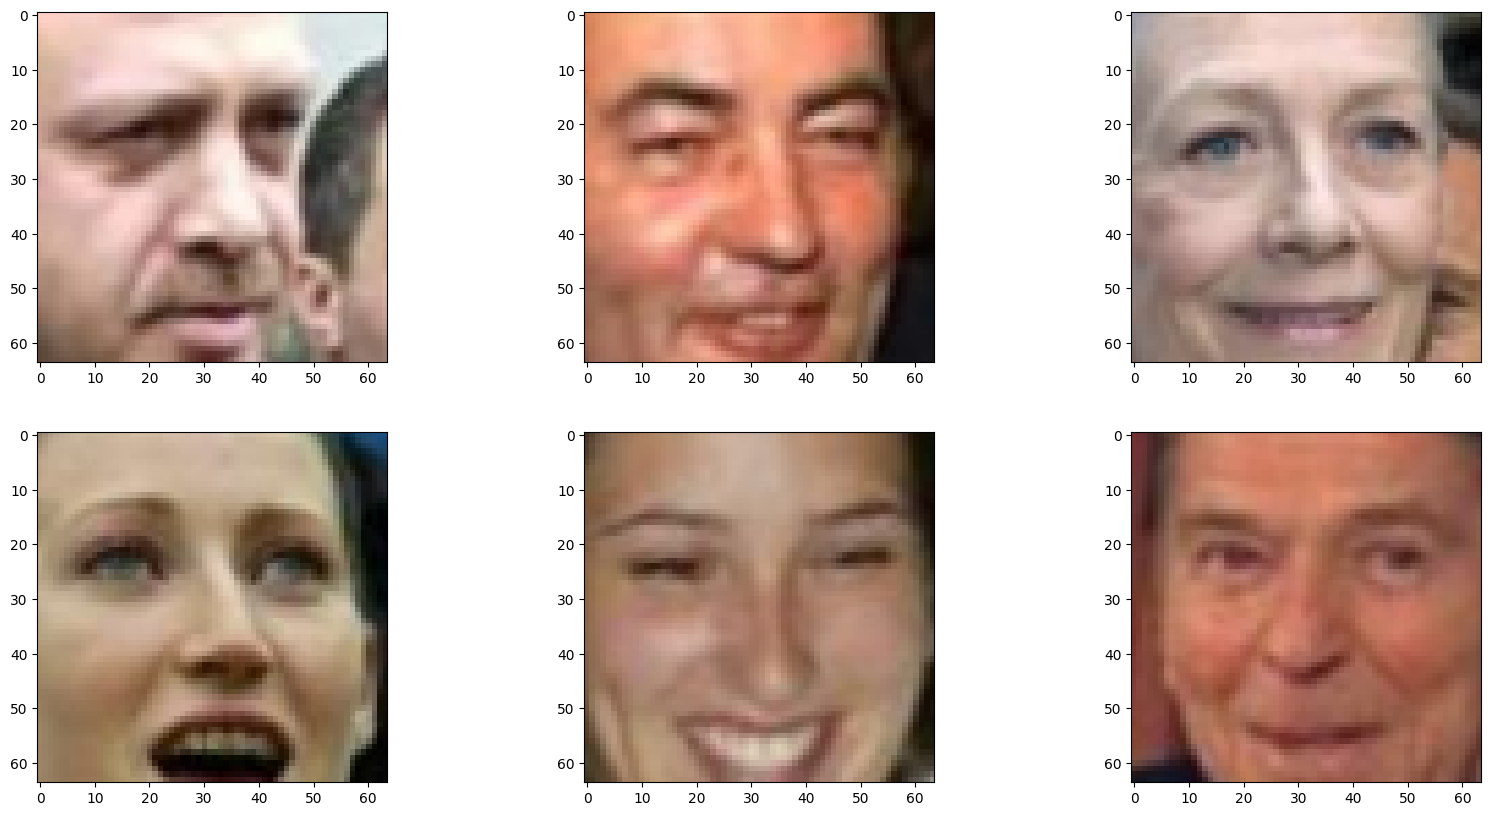

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_val, attrs_train, attrs_val = train_test_split(data, attrs, test_size=0.2, random_state=42)
# Show several images from the training set to get a visual impression of the dataset.
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(data_train[i])
plt.show()
# Convert the training and validation sets to torch tensors.
data_train = torch.Tensor(data_train)
data_val = torch.Tensor(data_val)
data_train = data_train.permute(0, 3, 1, 2)
data_val = data_val.permute(0, 3, 1, 2)
#scale
data_train_mean = data_train.mean()
data_train_std = data_train.std()
data_train_new = (data_train - data_train_mean) / data_train_std

train_loader = torch.utils.data.DataLoader(data_train, batch_size=16)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=16)

In [ ]:
print(data_train.shape)

torch.Size([10514, 3, 64, 64])


## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16 # выберите размер латентного вектора
from torch.optim.lr_scheduler import StepLR

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        # Encoder
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 16x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 16x16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x8x8
            nn.ReLU(),
            nn.Flatten(),
            # nn.Linear(8*128*8, 16),
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.Linear(16, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1), #16x64x64
            nn.Sigmoid()

        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):
        # print(x.shape, "Forward")
        x = self.enc1(x)
        # print(x.shape, "Forward1")
        latent_code = x
        x = self.dec1(x)
        # print(x.shape, "recon forward")
        reconstruction = x
        return reconstruction, latent_code
        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        return reconstruction, latent_code

In [ ]:
criterion = F.mse_loss
scheduler_step_size = 20
scheduler_gamma = 0.7
autoencoder = Autoencoder().to('cuda')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Здесь сказано "было бы неплохо", так что я не буду запариваться с отрисовкой этого, т.к. это не обязательно. Графики лоссов в конце будут, но после каждой эпохи их делать и отрисовывать рекострукцию не хочу

Epoch 1/50: train loss=0.007140539586544037, val loss=0.008530936203897
Epoch 2/50: train loss=0.006426243111491203, val loss=0.008166685700416565
Epoch 3/50: train loss=0.006137950345873833, val loss=0.007859966717660427
Epoch 4/50: train loss=0.005929253064095974, val loss=0.0074866050854325294
Epoch 5/50: train loss=0.0056932359002530575, val loss=0.007275268901139498
Epoch 6/50: train loss=0.005544045474380255, val loss=0.007112506777048111
Epoch 7/50: train loss=0.0053574880585074425, val loss=0.007031497545540333
Epoch 8/50: train loss=0.005247976165264845, val loss=0.006980341859161854
Epoch 9/50: train loss=0.005242731422185898, val loss=0.006969115696847439
Epoch 10/50: train loss=0.005126034840941429, val loss=0.007120857480913401
Epoch 11/50: train loss=0.004988064523786306, val loss=0.0076552992686629295
Epoch 12/50: train loss=0.005008738022297621, val loss=0.006959306541830301
Epoch 13/50: train loss=0.004657266195863485, val loss=0.00712762912735343
Epoch 14/50: train lo

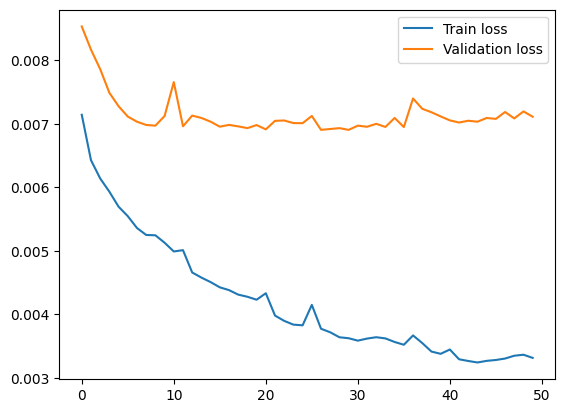

In [ ]:
train_losses = []
val_losses = []

for epoch in range(50):
    autoencoder.train()
    # Forward pass
    for X_batch in train_loader:
      # print(X_batch.shape)
      reconstructions, latent_codes = autoencoder(X_batch.to('cuda'))
      # print(reconstructions.shape, "recon")
      # Compute loss
      loss = criterion(reconstructions, X_batch.to('cuda'))

      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Add the losses to the lists
    train_losses.append(loss.item())
    autoencoder.eval()
    # Get the validation loss
    with torch.no_grad():
        for X_batch in val_loader:
            reconstructions_val, latent_codes_val = autoencoder(X_batch.to('cuda'))
            val_loss = criterion(reconstructions_val, X_batch.to('cuda'))
        val_losses.append(val_loss.item())
    scheduler.step()
    # Print the losses
    print(f"Epoch {epoch + 1}/{50}: train loss={loss.item()}, val loss={val_loss.item()}")
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

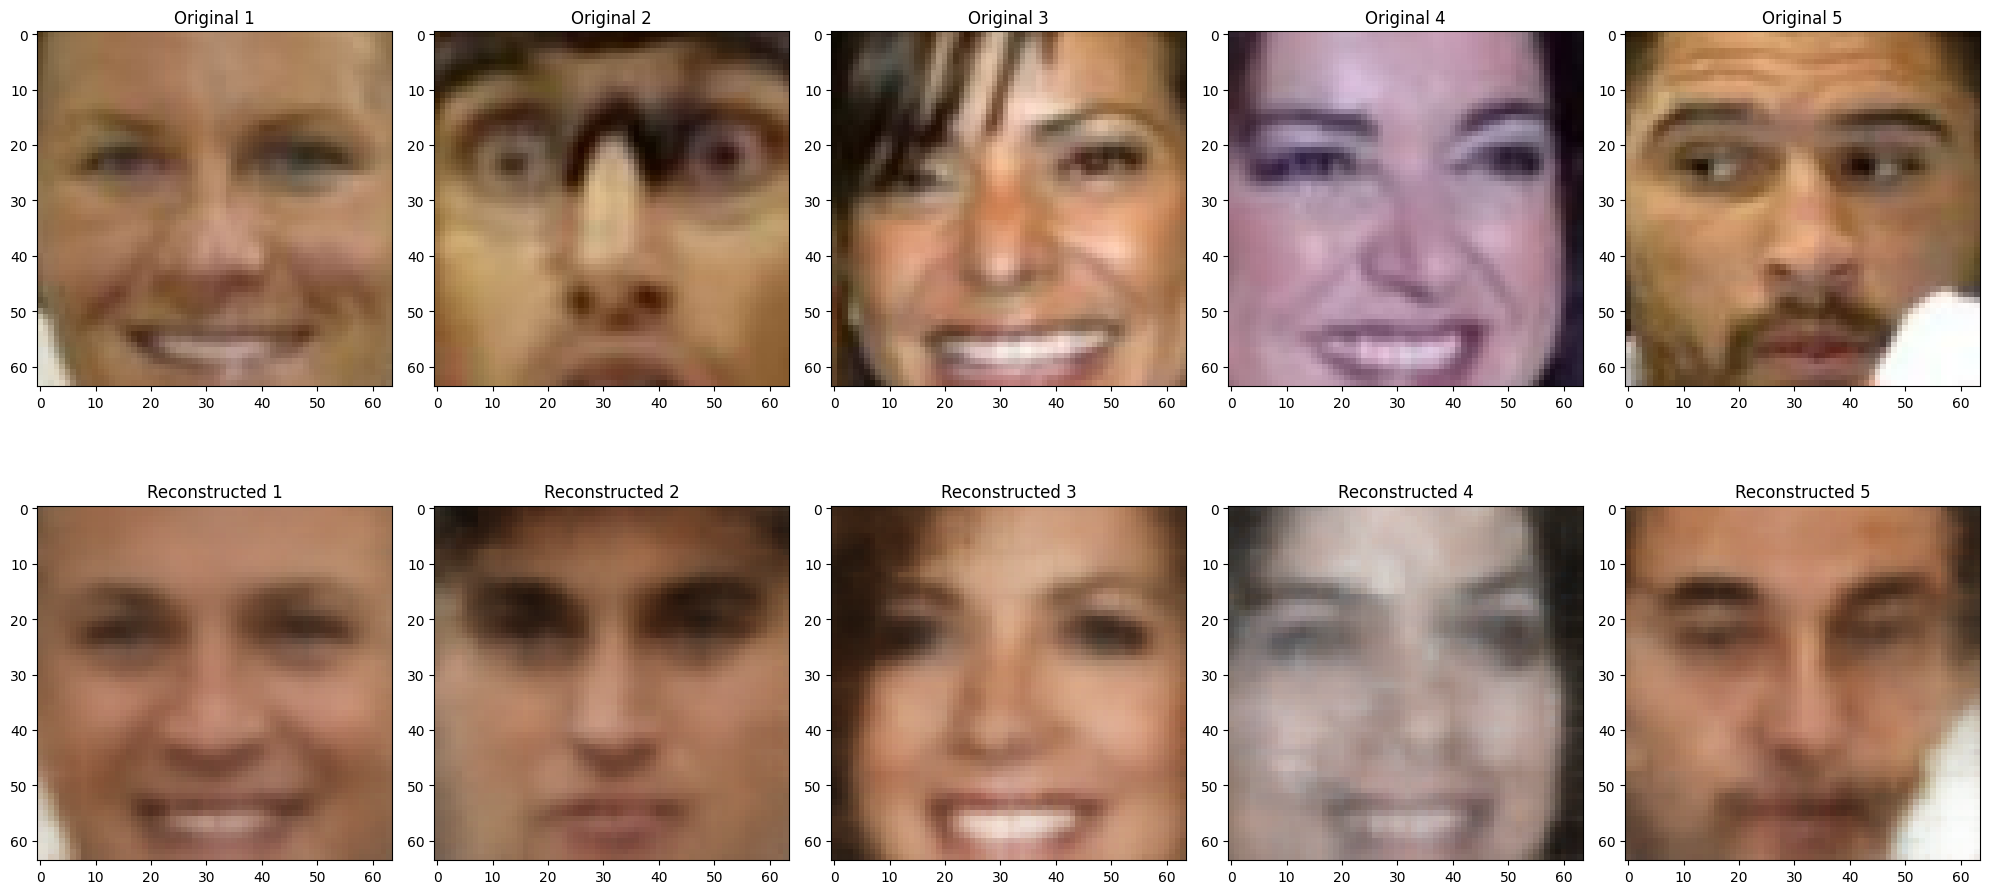

In [ ]:
X = 5

# Получаем реконструкции для первых X картинок из val выборки
reconstructions_val, _ = autoencoder(data_val[:X].to('cuda'))

# Подготовка изображений для отображения
original_images = data_val[:X].cpu().detach().numpy().transpose(0, 2, 3, 1)
reconstructed_images = reconstructions_val.cpu().detach().numpy().transpose(0, 2, 3, 1)

# Отображение оригинальных и восстановленных изображений
plt.figure(figsize=(20, 10))
for i in range(X):
    plt.subplot(2, X, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Original {i + 1}")

    plt.subplot(2, X, i + X + 1)
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed {i + 1}")

plt.tight_layout()
plt.show()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

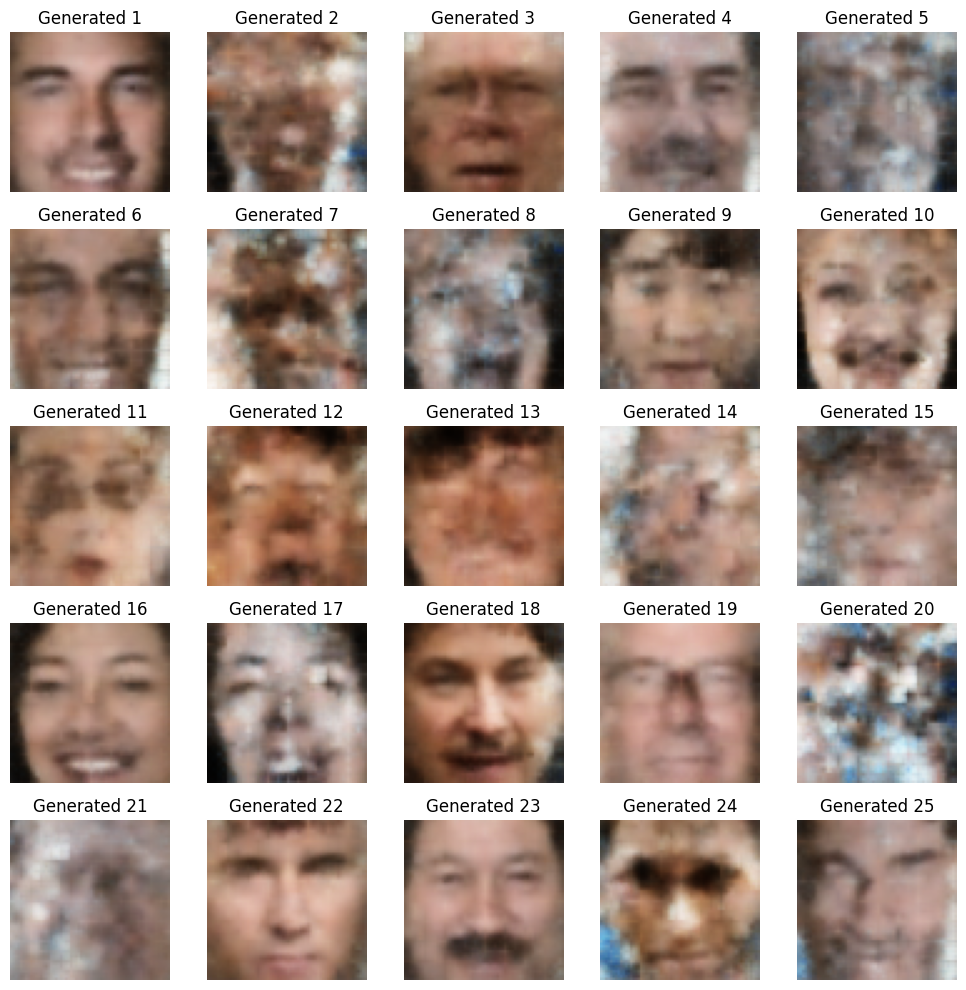

In [ ]:
z = np.random.randn(25, 16)
z = torch.from_numpy(z).float().to('cuda')

# Подача случайных векторов на декодер
output = autoencoder.dec1(z)
output = output.cpu().detach().numpy().transpose(0, 2, 3, 1)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(output[i])
    plt.title(f"Generated {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Если сделать маленький latent space то будут большие лоссы, но нормальные сэмплы. А с большим latent space получаются неразличимые фигни вместо лиц...

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
sad = [7506, 5458, 10491, 6321, 2529, 12992, 3559, 11571, 8504, 10506, 5641, 7506, 5458, 5163, 1234, 12688, 11011, 12298, 11912, 2000, 9866, 11381]
sad_vecs = []
happy_vecs = []
for i in sad:
    abob1 = torch.Tensor(data[i]).to('cuda').permute(2, 0, 1)
    a = autoencoder.enc1(abob1.unsqueeze(0))
    sad_vecs.append(a)
happy = [8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
             2031,  1955,  9004,   459,  6166,   682,   983,  9165,  9005,
             1605, 12606, 12607,   135]
for i in happy:
    abob1 = torch.Tensor(data[i]).to('cuda').permute(2, 0, 1)
    a = autoencoder.enc1(abob1.unsqueeze(0))
    happy_vecs.append(a)

In [ ]:
sad_tensors = torch.stack(sad_vecs)
happy_tensors = torch.stack(happy_vecs)

# Вычисляем средние латентные векторы для грустных и счастливых лиц
mean_sad = torch.mean(sad_tensors, dim=0)
mean_happy = torch.mean(happy_tensors, dim=0)

# Вычисляем вектор улыбки
smile_vector = mean_happy - mean_sad

# Проверим размерность вектора улыбки
print("Размерность вектора улыбки:", smile_vector.size())

Размерность вектора улыбки: torch.Size([1, 16])


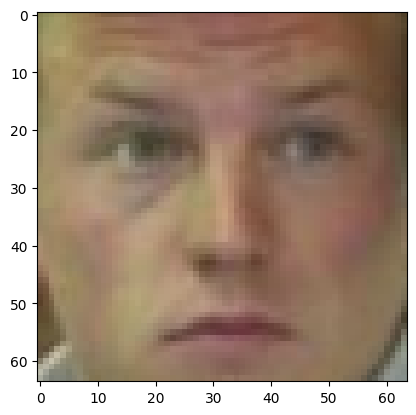

In [ ]:
plt.imshow(data[7506])

In [ ]:
new = sad_vecs[0] + smile_vector

In [ ]:
output_image = autoencoder.dec1(new)

torch.Size([1, 3, 64, 64])


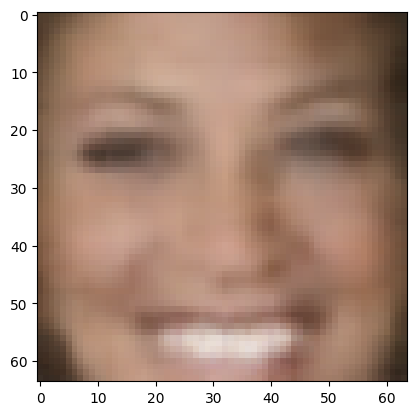

In [ ]:
print(output_image.shape)
output_image = output_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(output_image)

Лицо стало немного более женственным. Нет, это не баг, это фича!

In [ ]:
#Тут я отбирал фотки с улыбками и неулыбками. Времени красиво оформлять ноутбук нет, простите(((
#Скоро сессия и работа
sorted_frowning = attrs.sort_values(by='Smiling', ascending=False)
print(sorted_frowning['Smiling'].head(22).index)

Int64Index([ 8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
             2031,  1955,  9004,   459,  6166,   682,   983,  9165,  9005,
             1605, 12606, 12607,   135],
           dtype='int64')


Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [7]:
from torchvision import transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 256595842.97it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26948986.39it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68885438.77it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22952444.30it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
# class VAE(nn.Module):
#     def __init__(self):
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста",
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

#     def encode(self, x):
#         <реализуйте forward проход энкодера
#         в качестве ваозвращаемых переменных -- mu и logsigma>

#         return mu, logsigma

#     def gaussian_sampler(self, mu, logsigma):
#         if self.training:
#             <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
#         else:
#             # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
#             # на инференсе выход автоэнкодера должен быть детерминирован.
#             return mu

#     def decode(self, z):
#         <реализуйте forward проход декодера
#         в качестве возвращаемой переменной -- reconstruction>

#         return reconstruction

#     def forward(self, x):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
#         return mu, logsigma, reconstruction

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, 20)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logsigma = self.fc_logsigma(encoded)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, 28)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, 28)

        self.decoder = nn.Sequential(
            nn.Linear(28, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        # print("step 0E done")
        encoded = self.encoder(x)
        # print("step 1E done")
        # print(encoded.shape)
        mu = self.fc_mu(encoded)
        # print("step 2E done")
        logsigma = self.fc_logsigma(encoded)
        # print("step 3E done")
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        # print(reconstruction.shape, "recon")
        return reconstruction

    def forward(self, x):
        # print("step 0 done")
        mu, logsigma = self.encode(x)
        # print("step 1 done")
        z = self.gaussian_sampler(mu, logsigma)
        # print("step 2 done")
        reconstruction = self.decode(z)
        # print("step 3 done")
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
# def KL_divergence(mu, logsigma):
#     """
#     часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
#     """
#     loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
#     return

# def log_likelihood(x, reconstruction):
#     """
#     часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
#     """
#     loss = <binary cross-entropy>
#     return loss(reconstruction, x)

# def loss_vae(x, mu, logsigma, reconstruction):
#     return <соедините тут две компоненты лосса. Mind the sign!>

In [11]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    # print("KL Done")
    return loss

def log_likelihood(x, reconstruction):
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    # print("log Done")
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

vautoencoder = VAE()

optimizer = optim.Adam(vautoencoder.parameters())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vautoencoder.to(device)

# Обучение модели
n_epochs = 10

for epoch in range(n_epochs):
    vautoencoder.train()
    train_loss = 0.0

    for X_batch, y in train_loader:
        # print(X_batch)
        data = X_batch.to(device)
        optimizer.zero_grad()
        # print(data.shape)
        mu, logsigma, reconstruction = vautoencoder(data)
        loss = criterion(data, mu, logsigma, reconstruction)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Выводим среднее значение функции потерь для эпохи
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1/10, Loss: 126.6719
Epoch 2/10, Loss: 108.4714
Epoch 3/10, Loss: 106.3575
Epoch 4/10, Loss: 105.1828
Epoch 5/10, Loss: 104.3921
Epoch 6/10, Loss: 103.8048
Epoch 7/10, Loss: 103.3231
Epoch 8/10, Loss: 102.9474
Epoch 9/10, Loss: 102.5597
Epoch 10/10, Loss: 102.2899


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

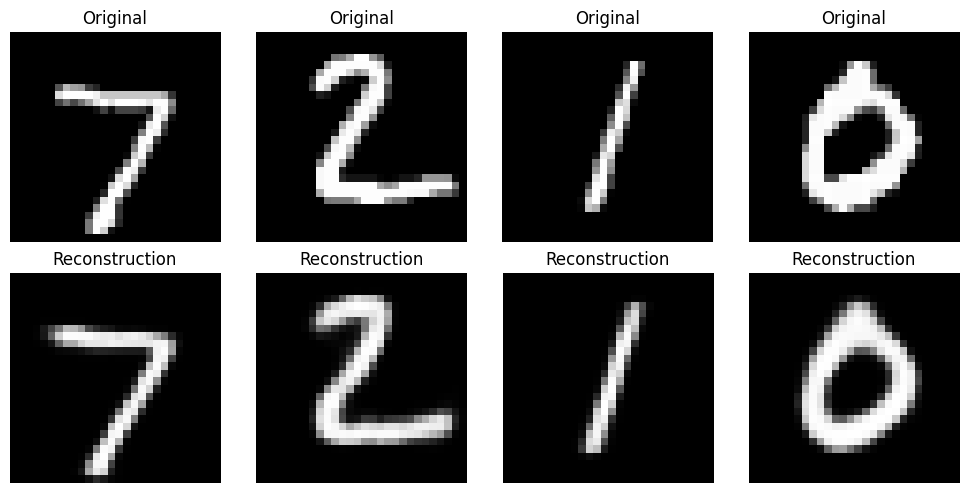

In [ ]:
# Предполагая, что у вас есть val_loader для валидационной выборки
data_iter = iter(test_loader)
images, _ = next(data_iter)

# Передача изображений через модель VAE и получение их реконструкций
vautoencoder.eval()
with torch.no_grad():
    mu, logsigma, reconstructions = vautoencoder(images.to(device))

# Вывод оригинальных изображений и их реконструкций
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

for i in range(4):
    axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(reconstructions[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstruction')

plt.tight_layout()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

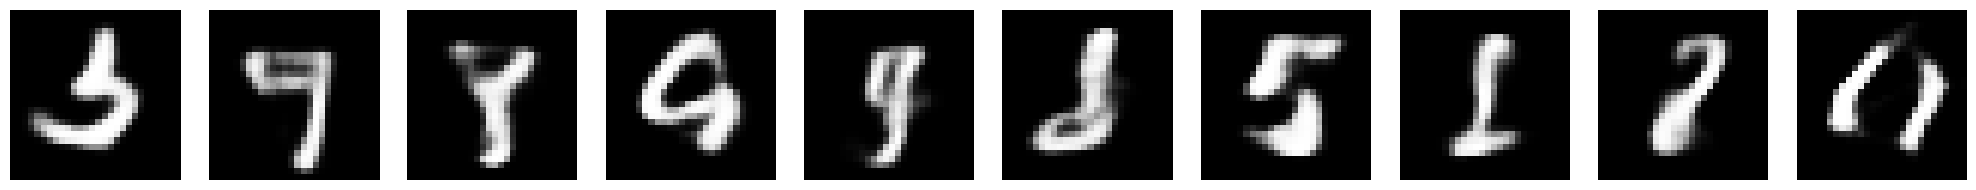

In [ ]:

# Сэмплирование случайных векторов из нормального распределения для входа в декодер
z = torch.tensor(np.random.normal(0, 1, (10, 20))).float().to(device)  # 20 - размер латентного пространства

# Передача сэмплированных векторов через декодер модели VAE
vautoencoder.eval()
with torch.no_grad():
    generated = vautoencoder.decode(z)

# Вывод сгенерированных изображений
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))

for i in range(10):
    axes[i].imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

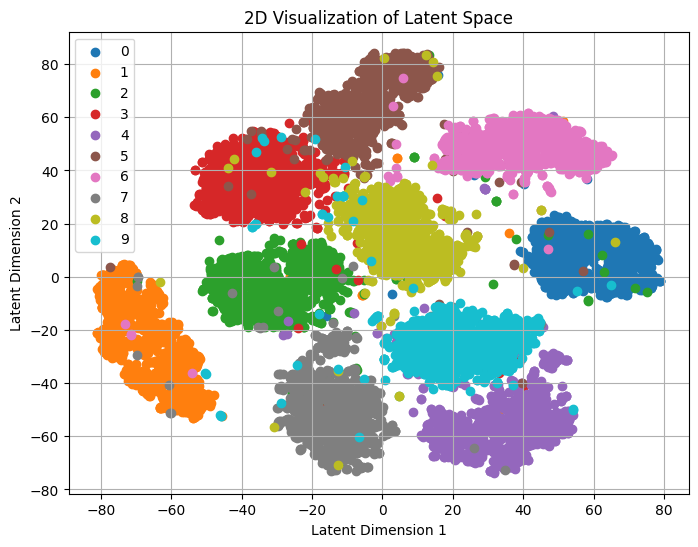

In [ ]:
from sklearn.manifold import TSNE

# Получение латентных представлений изображений тестового датасета
vautoencoder.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        mu, _ = vautoencoder.encode(images.to(device))
        latent_vectors.append(mu.cpu().detach())
        labels.extend(targets)

latent_vectors = torch.cat(latent_vectors, dim=0)
labels = np.array(labels)

# Применение TSNE для уменьшения размерности до 2
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Визуализация двумерных представлений с цветовой разметкой для разных цифр
plt.figure(figsize=(8, 6))

for i in range(10):  # Предполагается, что у вас 10 классов (цифры от 0 до 9)
    indices = np.where(labels == i)
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=str(i))

plt.title('2D Visualization of Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


Что вы думаете о виде латентного представления?

Думаю, что красиво получилось!

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>

        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

In [12]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=512),  # Входной размер - 28x28 (784) пикселей + 10 классов
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)  # Размер латентного пространства
        self.fc_logsigma = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim + 10, out_features=128),  # Латентный вектор + 10 классов
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784),  # Выходной размер - 28x28 (784) пикселей
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        x = torch.cat([x.view(-1, 784), class_num], dim=1)  # Конкатенация изображения и класса
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu

    def decode(self, z, class_num):
        z = torch.cat([z, class_num], dim=1)  # Конкатенация латентного вектора и класса
        return self.decoder(z)

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction


In [40]:
epochs = 10
latent_dim = 20

cvae = CVAE()

# Определение функции потерь и оптимизатора
criterion = loss_vae
optimizer = optim.Adam(cvae.parameters())
# Обучение модели
cvae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Подготовка данных для модели (векторизация изображений и one-hot кодирование классов)
        data = data.view(-1, 784)
        data = data
        target = target
        target_onehot = torch.zeros(target.size(0), 10)
        target_onehot = target_onehot
        target_onehot.scatter_(1, target.view(-1, 1), 1)

        # Передача данных в модель и вычисление потерь
        mu, logsigma, reconstruction = cvae(data, target_onehot)
        loss = criterion(data, mu, logsigma, reconstruction)

        # Обратное распространение и обновление весов
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/10], Loss: 4868.7640
Epoch [2/10], Loss: 3875.4144
Epoch [3/10], Loss: 3702.5926
Epoch [4/10], Loss: 3622.3309
Epoch [5/10], Loss: 3572.7778
Epoch [6/10], Loss: 3539.0172
Epoch [7/10], Loss: 3511.5622
Epoch [8/10], Loss: 3491.1172
Epoch [9/10], Loss: 3473.7288
Epoch [10/10], Loss: 3459.8873


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

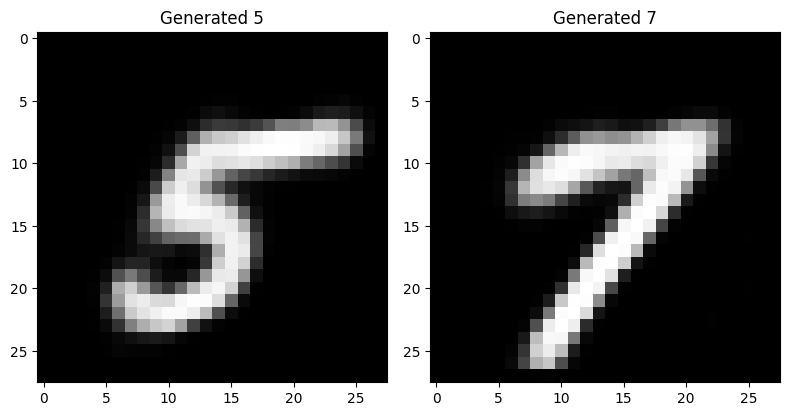

In [41]:
latent_vector = torch.randn(1, latent_dim)  # Размер латентного вектора

# Создаем one-hot векторы классов для цифр 5 и 7
class_5 = torch.zeros(1, 10)
class_5[:, 5] = 1  # Устанавливаем элемент, соответствующий цифре 5, в единицу
class_5
class_7 = torch.zeros(1, 10)
class_7[:, 7] = 1  # Устанавливаем элемент, соответствующий цифре 7, в единицу

# Генерируем изображения цифр 5 и 7 из одного латентного вектора
reconstruction_5 = cvae.decode(latent_vector, class_5)
reconstruction_7 = cvae.decode(latent_vector, class_7)
reconstruction_5_np = reconstruction_5.view(-1, 28, 28).squeeze().detach().numpy()


reconstruction_7_np = reconstruction_7.view(-1, 28, 28).squeeze().detach().numpy()

# Выведем сгенерированные изображения цифр 5 и 7 на экран
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(reconstruction_5_np, cmap='gray')
axes[0].set_title('Generated 5')

axes[1].imshow(reconstruction_7_np, cmap='gray')
axes[1].set_title('Generated 7')

plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Получение латентных представлений для тестового датасета
latent_vectors = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        images, class_labels = batch
        class_num_onehot = torch.zeros(class_labels.size(0), 10)
        class_num_onehot.scatter(1, class_labels.view(-1, 1), 1)
        mu, _, class_num = cvae(images, class_num_onehot)
        latent_vectors.append(mu.detach())
        labels.append(class_num.detach())

latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

# Применение TSNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

In [60]:
print(latent_tsne)
print(labels, len(labels))
labels_argmax = np.argmax(labels, axis=1)
print(labels_argmax)

[[-22.26926    69.6298   ]
 [ 70.83536   -34.704044 ]
 [-77.70292   -13.605109 ]
 ...
 [-31.178165   29.9021   ]
 [-46.331924  -35.91379  ]
 [  1.6900667 -13.531626 ]]
tensor([[1.0956e-05, 1.1632e-05, 1.3522e-05,  ..., 1.2232e-05, 1.1090e-05,
         1.0478e-05],
        [7.1057e-08, 1.0900e-07, 8.7093e-08,  ..., 9.5302e-08, 1.0074e-07,
         1.0786e-07],
        [1.7353e-08, 1.3695e-08, 1.8147e-08,  ..., 1.3155e-08, 8.2070e-09,
         2.3107e-08],
        ...,
        [7.9913e-06, 5.9301e-06, 7.4291e-06,  ..., 5.3370e-06, 4.0196e-06,
         6.2827e-06],
        [5.3701e-07, 6.7915e-07, 7.6580e-07,  ..., 4.7279e-07, 3.4562e-07,
         7.1549e-07],
        [6.6788e-05, 5.8799e-05, 6.6791e-05,  ..., 4.6632e-05, 3.7029e-05,
         6.4249e-05]]) 10000
tensor([518, 571, 627,  ..., 628, 596, 264])


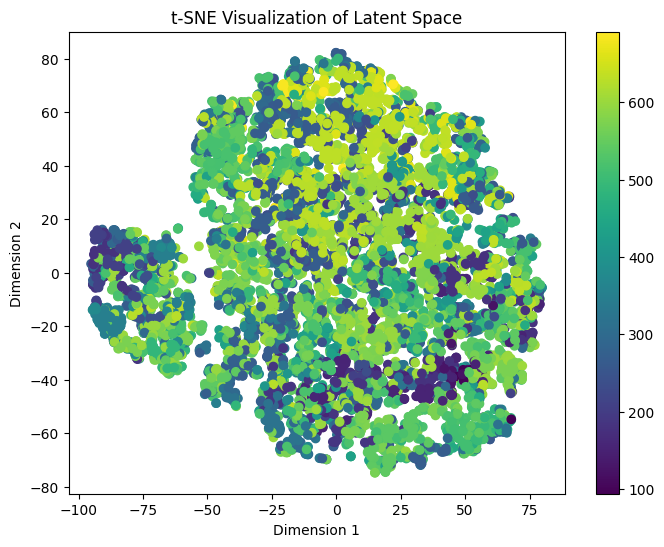

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels_argmax, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Тут требуется небольшое пояснение. Я делал последний пункт за 2 часа до дедлайна и в процессе воспользовался костылём в виде one-hot encoding'а просто чтобы код работал)))) По итогу имею то, что я не смог обратно вернуть числа в от 0 до 9 и нормально вывести график. Однако, по графику видно, что значения тут не кластерезированы как с VAE, что является правильным, в соответствии со словами людей из чата по вопросам домашек в DLS)

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>